In [1]:
# essentials
import numpy as np 
import pandas as pd 

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# time series algorithm
from fbprophet import Prophet
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
from fbprophet.plot import add_changepoints_to_plot

# reproducibility
np.random.seed(34)

# Jupyter magic
%reload_ext autoreload
%autoreload 2
%matplotlib inline


Importing plotly failed. Interactive plots will not work.


In [2]:
df=pd.read_csv('/Users/user/PycharmProjects/EU inflation forecasting/archive/RSAFS.csv')
df.head()

realtime_start realtime_end        date   value
0     2019-12-06   2019-12-06  1992-01-01  164095
1     2019-12-06   2019-12-06  1992-02-01  164213
2     2019-12-06   2019-12-06  1992-03-01  163721
3     2019-12-06   2019-12-06  1992-04-01  164709
4     2019-12-06   2019-12-06  1992-05-01  165612

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334 entries, 0 to 333
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   realtime_start  334 non-null    object
 1   realtime_end    334 non-null    object
 2   date            334 non-null    object
 3   value           334 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 10.6+ KB


In [4]:
df_prep = df.drop(['realtime_start','realtime_end'], axis = 1)
df_final = df_prep.rename(columns = {'date' : 'ds', 'value' : 'y'})
df_final['ds']= pd.to_datetime(df_final['ds']) + pd.tseries.offsets.MonthEnd(0)
df_final.head()

ds       y
0 1992-01-31  164095
1 1992-02-29  164213
2 1992-03-31  163721
3 1992-04-30  164709
4 1992-05-31  165612

In [5]:
def is_christmas(ds):
    date = pd.to_datetime(ds)
    return (date.month > 11)
df_final['christmas_time'] = df_final['ds'].apply(is_christmas)
df_final['no_christmas'] = ~df_final['ds'].apply(is_christmas)


In [6]:
train = df_final[:331]
test = df_final[331:]
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 331 to 333
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   ds              3 non-null      datetime64[ns]
 1   y               3 non-null      int64         
 2   christmas_time  3 non-null      bool          
 3   no_christmas    3 non-null      bool          
dtypes: bool(2), datetime64[ns](1), int64(1)
memory usage: 186.0 bytes


In [7]:
#baseline
m = Prophet(changepoint_prior_scale = 2)
m.fit(train)
future = m.make_future_dataframe(periods = 3,freq = 'm')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds           yhat     yhat_lower     yhat_upper
329 2019-06-30  515660.020802  510965.011306  520592.033102
330 2019-07-31  517369.330628  512705.843647  521980.962471
331 2019-08-31  518438.588236  513658.723071  523253.611702
332 2019-09-30  518179.827818  512738.721087  522645.061740
333 2019-10-31  520140.936903  515627.820762  525268.868341

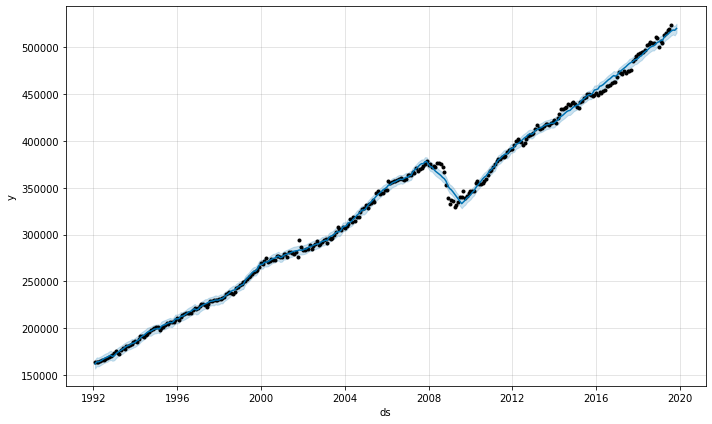

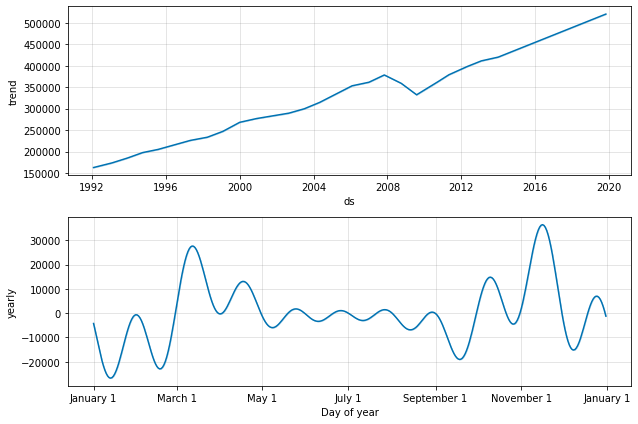

In [8]:
fig = m.plot(forecast)
figg = m.plot_components(forecast)


In [9]:
#check_changepoints and change the amount and time-interval then, if the model doesn't catch all of them
m1 = Prophet(yearly_seasonality = 4, seasonality_prior_scale = 0.5, changepoint_prior_scale = 1, changepoint_range = 0.9)
#m1.add_seasonality(name='monthly', period=30.5, fourier_order=5)
#seasonality.mode = "multiplicative" - when seasonality amplitude isn't stable
m1.add_country_holidays(country_name='US')
m1.fit(train)
future1 = m1.make_future_dataframe(periods = 3,freq = 'm')
forecast1 = m1.predict(future1)
forecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds           yhat     yhat_lower     yhat_upper
329 2019-06-30  520614.147307  516205.166686  525187.560951
330 2019-07-31  522906.014993  518508.064123  527493.227810
331 2019-08-31  524422.182714  519943.619833  528969.738549
332 2019-09-30  525939.879572  520888.905151  530920.140253
333 2019-10-31  528023.154577  523131.605286  532634.424374

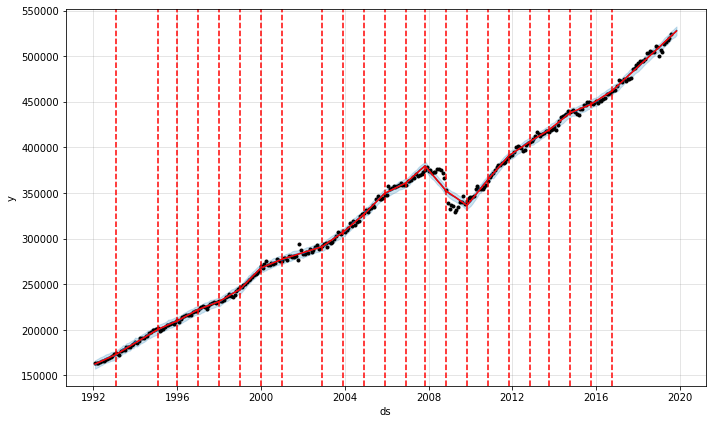

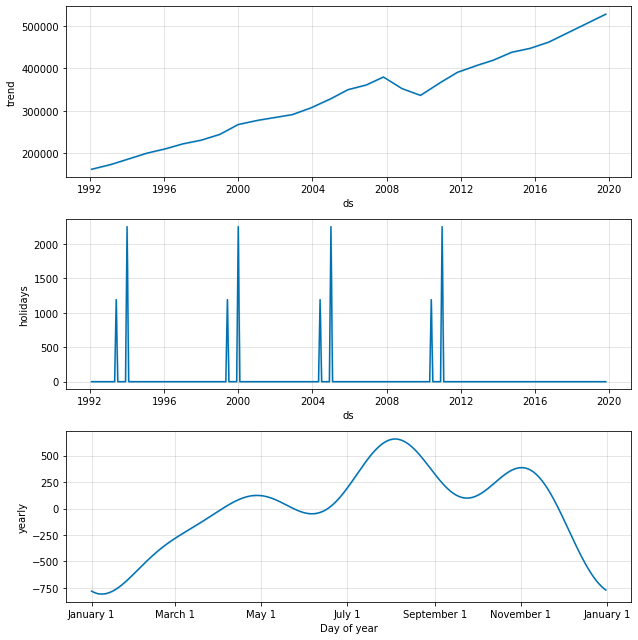

In [10]:
fig1 = m1.plot(forecast1)
figg1 = m1.plot_components(forecast1)
a = add_changepoints_to_plot(fig1.gca(),m1,forecast1)

In [11]:
#Cross val
import ipywidgets as widgets
from ipywidgets import IntProgress
train_cv1 = cross_validation(m1, horizon = '90 days')#12 months


INFO:fbprophet:Making 214 forecasts with cutoffs between 1993-02-02 00:00:00 and 2019-05-02 00:00:00


INFO:fbprophet:n_changepoints greater than number of observations. Using 10.
INFO:fbprophet:n_changepoints greater than number of observations. Using 11.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.
INFO:fbprophet:n_changepoints greater than number of observations. Using 14.
INFO:fbprophet:n_changepoints greater than number of observations. Using 16.
INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.


In [12]:
df_p1 = performance_metrics(train_cv1)
df_p1.head()

horizon           mse         rmse          mae      mape     mdape  \
0  9 days  4.451122e+07  6671.672991  4046.486618  0.012509  0.007354   
1 10 days  4.367215e+07  6608.490391  3915.788773  0.012009  0.007300   
2 11 days  6.018058e+07  7757.614346  4545.912536  0.013497  0.007396   
3 12 days  6.422380e+07  8013.975244  4760.108549  0.014291  0.008209   
4 13 days  6.489586e+07  8055.796741  4856.992821  0.014682  0.008678   

   coverage  
0  0.447619  
1  0.473016  
2  0.444444  
3  0.444444  
4  0.422619

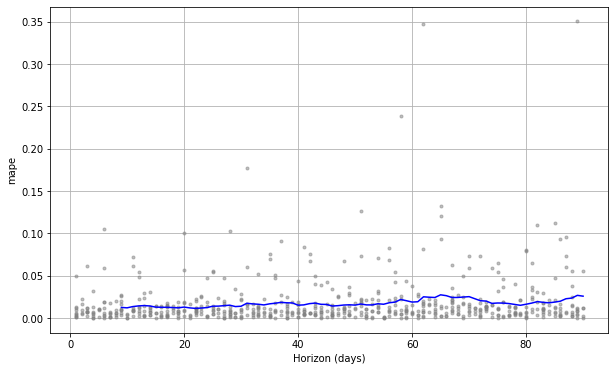

In [13]:
from fbprophet.plot import plot_cross_validation_metric
#fig = plot_cross_validation_metric(train_cv, metric='mape')
fig1 = plot_cross_validation_metric(train_cv1, metric='mape')


In [23]:
#prediction
m1_final = Prophet(yearly_seasonality = 12, n_changepoints=18, changepoint_prior_scale = 1, changepoint_range = 0.9)
m1_final.add_country_holidays(country_name='US')
m1_final.fit(df_final)
future1_final = m1_final.make_future_dataframe(periods = 3,freq = 'm')
forecast1_final = m1_final.predict(future1_final)
comp = forecast1_final[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

comp.tail()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds           yhat     yhat_lower     yhat_upper
332 2019-09-30  526498.338740  521340.445153  531819.168808
333 2019-10-31  529063.307782  523178.178454  534769.257005
334 2019-11-30  532793.738860  527020.403201  538405.438050
335 2019-12-31  533077.573647  527412.624299  538392.147016
336 2020-01-31  534566.605278  529008.586649  539577.167958

In [22]:
#проверка модели м1 с тестом

#m1_test = m1_test['yhat']
comp_final = test.set_index('ds').join(comp.set_index('ds'))
comp_final = comp_final[['y','yhat']]

comp_final['mean_rmse'] = np.sqrt(np.mean((comp_final['yhat'] - comp_final['y'])**2)) 
comp_final


y           yhat    mean_rmse
ds                                            
2019-08-31  526862  526261.084305  1685.958822
2019-09-30  525157  526498.338740  1685.958822
2019-10-31  526540  529063.307782  1685.958822



# hyperparam tuning
import itertools


param_grid = {  
    'changepoint_prior_scale': [0.01, 0.1, 0.5, 1.0],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

#Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

#Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train)  # Fit model with given params
    df_cv = cross_validation(m, horizon='90 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

#Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)